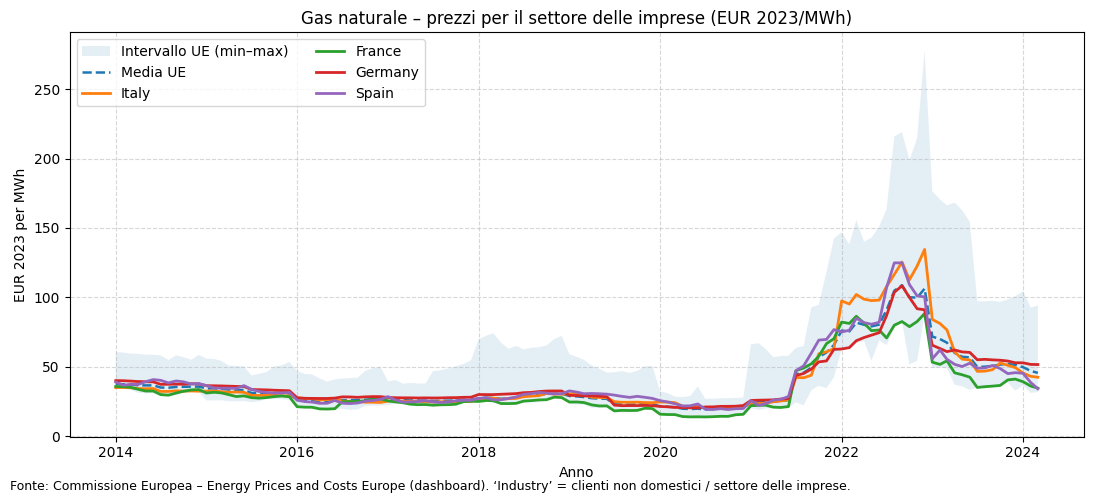

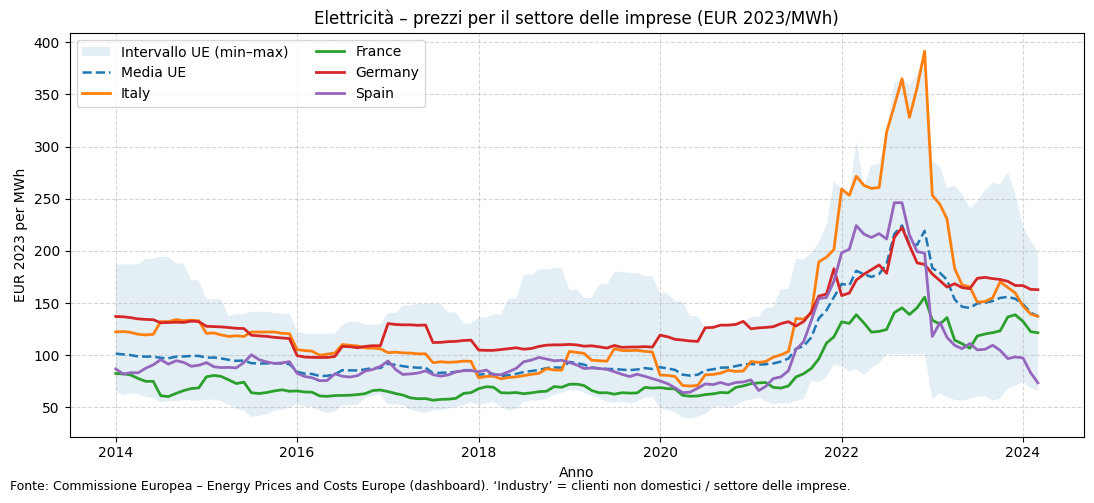

In [0]:
# -*- coding: utf-8 -*-
"""
Serie temporali dei prezzi energetici per il settore delle imprese (clienti non domestici):
Italia, Francia, Germania, Spagna.
Fonte: Commissione Europea – Energy Prices and Costs Europe (dashboard).
CSV scaricabili dal link ufficiale nella docstring.
"""

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# --- lettura robusta ---

def read_csv_robust(path: str) -> pd.DataFrame:
    # autodetect separatore, gestisce BOM; pulisce header
    df = pd.read_csv(path, sep=None, engine="python", encoding="utf-8-sig")
    df.columns = [c.strip() for c in df.columns]
    return df

def _norm(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[\s_/()-]+", "", s)
    return s

def find_col(df: pd.DataFrame, name: str) -> str:
    wanted = _norm(name)
    for c in df.columns:
        if _norm(c) == wanted:
            return c
    for c in df.columns:
        if wanted in _norm(c):
            return c
    raise KeyError(f"Colonna '{name}' non trovata. Presenti: {list(df.columns)}")

# --- plot multi-paese ---

def plot_multi_countries(file_path: str,
                         countries=("Italy","France","Germany","Spain"),
                         show_eu_band=True,
                         title="",
                         ylab="EUR 2023 per MWh",
                         save_png=False):
    df = read_csv_robust(file_path)

    col_date = find_col(df, "Category")          # es. '2014-1'
    col_euavg = find_col(df, "EU Average")
    col_eumin = find_col(df, "EU Min")
    col_eumax = find_col(df, "EU Max")
    country_cols = {c: find_col(df, c) for c in countries}

    # parsing data (YYYY-M)
    cat = df[col_date].astype(str).str.strip()
    cat = cat.str.replace(r"^(\d{4})-(\d{1})$", r"\1-0\2", regex=True)
    df["Date"] = pd.to_datetime(cat, format="%Y-%m", errors="coerce")
    df = df.sort_values("Date").dropna(subset=["Date"])

    # conversioni numeriche
    cols_to_num = [col_euavg, col_eumin, col_eumax] + list(country_cols.values())
    for c in cols_to_num:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # grafico
    fig, ax = plt.subplots(figsize=(11,5))
    if show_eu_band:
        ax.fill_between(df["Date"], df[col_eumin], df[col_eumax],
                        alpha=0.12, label="Intervallo UE (min–max)")
        ax.plot(df["Date"], df[col_euavg], linestyle="--", linewidth=1.8, label="Media UE")

    for name, col in country_cols.items():
        ax.plot(df["Date"], df[col], linewidth=2, label=name)

    ax.set_title(title)
    ax.set_xlabel("Anno")
    ax.set_ylabel(ylab)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(ncol=2)
    fig.text(
        0.01, 0.01,
        ("Fonte: Commissione Europea – Energy Prices and Costs Europe (dashboard). "
         "‘Industry’ = clienti non domestici / settore delle imprese."),
        ha="left", fontsize=9
    )
    plt.tight_layout()

    if save_png:
        out = Path(file_path).with_suffix("")
        out = Path(str(out) + "_IT_FR_DE_ES_timeseries.png")
        plt.savefig(out, dpi=200)
        print(f"Salvato: {out}")

    plt.show()

# ======= ESECUZIONE =======

# GAS
plot_multi_countries(
    file_path="Natural-Gas-Industry-retail-prices,-excluding-recoverable-taxes-and-levies-(EUR2023-MWh).csv",
    countries=("Italy","France","Germany","Spain"),
    title="Gas naturale – prezzi per il settore delle imprese (EUR 2023/MWh)"
)

# ELETTRICITÀ
plot_multi_countries(
    file_path="Electricity-Industry-retail-prices,-excluding-recoverable-taxes-and-levies-(EUR2023-MWh).csv",
    countries=("Italy","France","Germany","Spain"),
    title="Elettricità – prezzi per il settore delle imprese (EUR 2023/MWh)"
)
